In [55]:
"""In the backtest, the OOS return for date t is already
 the forward move from close(t) → close(t+1). 
 That is, full_ret is built from price[t+1]/price[t] − 1 while using the positions chosen at t; 
 then oos_ret = full_ret.reindex(test_dates) stamps that forward P&L on the bar date t itself. 
 So “buy at close t, sell at close t+1” is recorded on date t (entry day), not on t+1. 
 If you want to compare it to an exit‑day series, shift OOS down one row; 
 if you want entry‑day alignment, keep it as is."""
# Configuration
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import scipy.stats as stats
plt.style.use('default')
plt.rcParams['figure.figsize'] = (14, 10)
COST_BPS = 0.0005  # trading cost per rebalance (entry or exit)
ALLOCATION_FILE = "walkforward_positions.csv"  # positions export
RETURNS_FILE = "walkforward_oos_returns.csv"  # OOS returns export (date, return)
BTC_SYMBOL = "BTCUSDT"
DATA_DIRECTORY = "/Users/chinjieheng/Documents/data/binance_dailydata"

print(f"Allocation file: {ALLOCATION_FILE}")
print(f"Data directory: {DATA_DIRECTORY}")
# Load positions + returns + BTC benchmark
allocations_df = pd.read_csv(ALLOCATION_FILE)
allocations_df['date'] = pd.to_datetime(allocations_df['date'])

returns_df = pd.DataFrame()
returns_path = Path(RETURNS_FILE)

Allocation file: walkforward_positions.csv
Data directory: /Users/chinjieheng/Documents/data/binance_dailydata


In [56]:
if returns_path.exists():
    returns_df = pd.read_csv(returns_path, header=None, names=['date', 'oos_return'])
    returns_df['date'] = pd.to_datetime(returns_df['date'], errors='coerce')
    if hasattr(returns_df['date'], 'dt') and returns_df['date'].dt.tz is not None:
        returns_df['date'] = returns_df['date'].dt.tz_localize(None)
    returns_df = returns_df.dropna(subset=['date']).sort_values('date').reset_index(drop=True)
    print(f"Loaded returns: {len(returns_df)} rows from {returns_path}")
else:
    print(f"Returns file not found: {returns_path}")
    returns_df = pd.DataFrame()

btc_ret_df = pd.DataFrame()
btc_path = Path(DATA_DIRECTORY) / f"{BTC_SYMBOL}-1d-data.parquet"
if btc_path.exists():
    btc_df = pd.read_parquet(btc_path)
    if 'timestamp' in btc_df.columns:
        date_series = pd.to_datetime(btc_df['timestamp'], errors='coerce')
    elif 'date' in btc_df.columns:
        date_series = pd.to_datetime(btc_df['date'], errors='coerce')
    elif pd.api.types.is_datetime64_any_dtype(btc_df.index):
        date_series = pd.to_datetime(btc_df.index, errors='coerce')
    elif pd.api.types.is_numeric_dtype(btc_df.index):
        date_series = pd.to_datetime(btc_df.index.to_numpy(), unit='ms', errors='coerce')
    else:
        date_series = pd.to_datetime(btc_df.index, errors='coerce')
    btc_df = btc_df.reset_index(drop=True)
    date_series = pd.Series(date_series).reset_index(drop=True)
    btc_df['date'] = date_series
    if hasattr(btc_df['date'], 'dt') and btc_df['date'].dt.tz is not None:
        btc_df['date'] = btc_df['date'].dt.tz_localize(None)
    btc_df = btc_df.dropna(subset=['date']).sort_values('date')
    if 'close' in btc_df.columns:
        btc_df['btc_return'] = btc_df['close'].pct_change()
        btc_ret_df = btc_df[['date', 'btc_return']].dropna()
        print(f"Loaded BTC returns: {len(btc_ret_df)} rows from {btc_path.name}")
    else:
        print(f"BTC close column missing in {btc_path.name}")
else:
    print(f"BTC file not found: {btc_path}")

for col in ['oos_return', 'daily_return']:
    if col in allocations_df.columns:
        allocations_df[col] = pd.to_numeric(allocations_df[col], errors='coerce')

# Build continuous daily calendar so gaps disappear
start_date = allocations_df['date'].min()
end_date = allocations_df['date'].max()
dates_full = pd.DataFrame({'date': pd.date_range(start_date, end_date, freq='D')})

analysis_df = dates_full.merge(allocations_df, on='date', how='left')
if not returns_df.empty:
    analysis_df = analysis_df.merge(returns_df, on='date', how='left')
if not btc_ret_df.empty:
    analysis_df = analysis_df.merge(btc_ret_df, on='date', how='left')

# Flag actual rebalance days before any fill
analysis_df['rebalance_day'] = False
rebalance_cols = [c for c in ['long_allocations', 'short_allocations'] if c in analysis_df.columns]
if rebalance_cols:
    analysis_df['rebalance_day'] = analysis_df[rebalance_cols].notna().any(axis=1)

# Do not forward-fill allocations; treat missing as flat
for col in ['long_allocations', 'short_allocations']:
    if col in analysis_df.columns:
        analysis_df[col] = analysis_df[col].fillna('')

# Fill numeric exposures/meta with zeros (no carry)
zero_cols = [
    'long_positions', 'short_positions',
    'total_long_exposure', 'total_short_exposure', 'iteration',
    'train_start', 'train_end', 'test_start', 'test_end'
]
for col in zero_cols:
    if col in analysis_df.columns:
        analysis_df[col] = analysis_df[col].fillna(0)

# Track whether positions are active after fill
positions_cols = [c for c in ['long_allocations', 'short_allocations'] if c in analysis_df.columns]
if positions_cols:
    analysis_df['positions_active'] = analysis_df[positions_cols].notna().any(axis=1)

for col in ['oos_return', 'daily_return', 'btc_return']:
    if col in analysis_df.columns:
        analysis_df[col] = pd.to_numeric(analysis_df[col], errors='coerce')

# Align OOS returns to the entry day (positions on date apply to next-day PnL)
if 'oos_return' in analysis_df.columns:
    analysis_df['oos_return_entry'] = analysis_df['oos_return'].shift(-1)

allocations_df = analysis_df
RETURN_COL = None
if 'oos_return_entry' in allocations_df.columns:
    RETURN_COL = 'oos_return_entry'
elif 'oos_return' in allocations_df.columns:
    RETURN_COL = 'oos_return'
elif 'daily_return' in allocations_df.columns:
    RETURN_COL = 'daily_return'

print(f"Records (calendar): {len(allocations_df)}")
print(f"Date range: {allocations_df['date'].min().date()} -> {allocations_df['date'].max().date()}")
print(f"Columns: {list(allocations_df.columns)}")
print(f"Return column used: {RETURN_COL}")


Loaded returns: 809 rows from walkforward_oos_returns.csv
Loaded BTC returns: 2147 rows from BTCUSDT-1d-data.parquet
Records (calendar): 768
Date range: 2023-09-03 -> 2025-10-09
Columns: ['date', 'long_tickers', 'short_tickers', 'long_allocations', 'short_allocations', 'long_positions', 'short_positions', 'total_long_exposure', 'total_short_exposure', 'turnover', 'daily_return', 'iteration', 'train_start', 'train_end', 'test_start', 'test_end', 'oos_return', 'btc_return', 'rebalance_day', 'positions_active', 'oos_return_entry']
Return column used: oos_return_entry


In [57]:
# Compute long/short returns from allocations using forward price moves
from collections import defaultdict

COST_BPS = 0.0005  # 5 bps cost applied when positions change (rebalance)

def parse_allocations(val):
    out = {}
    if isinstance(val, str) and val:
        for part in val.split('|'):
            if ':' in part:
                sym, w = part.split(':', 1)
                try:
                    out[sym] = float(w)
                except ValueError:
                    continue
    return out

tickers = set()
for s in allocations_df.get('long_allocations', []):
    tickers.update(parse_allocations(s).keys())
for s in allocations_df.get('short_allocations', []):
    tickers.update(parse_allocations(s).keys())

price_frames = []
for sym in sorted(tickers):
    p = Path(DATA_DIRECTORY) / f"{sym}-1d-data.parquet"
    if not p.exists():
        continue
    df = pd.read_parquet(p)
    if 'timestamp' in df.columns:
        dates = pd.to_datetime(df['timestamp'], errors='coerce')
    elif 'date' in df.columns:
        dates = pd.to_datetime(df['date'], errors='coerce')
    elif pd.api.types.is_datetime64_any_dtype(df.index):
        dates = pd.to_datetime(df.index, errors='coerce')
    elif pd.api.types.is_numeric_dtype(df.index):
        dates = pd.to_datetime(df.index.to_numpy(), unit='ms', errors='coerce')
    else:
        dates = pd.to_datetime(df.index, errors='coerce')
    df = df.reset_index(drop=True)
    df['date'] = dates
    df = df.dropna(subset=['date'])
    if hasattr(df['date'], 'dt') and df['date'].dt.tz is not None:
        df['date'] = df['date'].dt.tz_localize(None)
    df = df.sort_values('date')
    if 'close' not in df.columns:
        continue
    df['fwd_return'] = df['close'].shift(-1) / df['close'] - 1.0
    ser = df.set_index('date')['fwd_return'].rename(sym).dropna()
    price_frames.append(ser)

if price_frames:
    asset_returns = pd.concat(price_frames, axis=1, sort=False)
    asset_returns = asset_returns[~asset_returns.index.duplicated(keep='first')].sort_index()
else:
    asset_returns = pd.DataFrame()

# prepare previous-day allocations to stamp PnL on exit day
allocations_df['long_allocations_prev'] = allocations_df.get('long_allocations', pd.Series([], dtype=object)).shift(1)
allocations_df['short_allocations_prev'] = allocations_df.get('short_allocations', pd.Series([], dtype=object)).shift(1)
mask_rebal = allocations_df.get('rebalance_day', pd.Series(False, index=allocations_df.index)).astype(bool)
mask_rebal_prev = mask_rebal.shift(1).fillna(False)

def compute_entry_returns(row):
    date = row['date']
    if asset_returns.empty or date not in asset_returns.index:
        return pd.Series({'long_return_mtm': 0.0, 'short_return_mtm': 0.0})
    rets = asset_returns.loc[date]
    long_w = parse_allocations(row.get('long_allocations', ''))
    short_w = parse_allocations(row.get('short_allocations', ''))
    long_ret = sum(rets.get(sym, 0.0) * w for sym, w in long_w.items())
    short_ret = sum(rets.get(sym, 0.0) * w for sym, w in short_w.items())
    return pd.Series({'long_return_mtm': long_ret, 'short_return_mtm': short_ret})

def compute_exit_returns(row):
    date = row['date']
    if asset_returns.empty or date not in asset_returns.index:
        return pd.Series({'long_return_mtm': 0.0, 'short_return_mtm': 0.0})
    rets = asset_returns.loc[date]
    long_w = parse_allocations(row.get('long_allocations_prev', ''))
    short_w = parse_allocations(row.get('short_allocations_prev', ''))
    long_ret = sum(rets.get(sym, 0.0) * w for sym, w in long_w.items())
    short_ret = sum(rets.get(sym, 0.0) * w for sym, w in short_w.items())
    return pd.Series({'long_return_mtm': long_ret, 'short_return_mtm': short_ret})

if allocations_df.empty:
    print('No allocations; skipping side return computation.')
else:
    # entry-day mtm (positions at date, fwd return date->date+1)
    side_entry = allocations_df.apply(compute_entry_returns, axis=1)
    allocations_df[['long_return_mtm', 'short_return_mtm']] = side_entry
    allocations_df['net_return_mtm'] = allocations_df['long_return_mtm'] + allocations_df['short_return_mtm']
    allocations_df.loc[~mask_rebal, ['long_return_mtm', 'short_return_mtm', 'net_return_mtm']] = 0.0

    

    # Apply trading cost on rebalance days to entry and exit PnL
   
    allocations_df['net_return_mtm'] = allocations_df['net_return_mtm'] - (mask_rebal.astype(float) * COST_BPS)



    print(f"Computed side returns for {side_entry.dropna().shape[0]} rows out of {len(allocations_df)}")


Computed side returns for 768 rows out of 768


/var/folders/4j/50_b76mn3qj360c47nzkyxdc0000gn/T/ipykernel_98066/2047384915.py:62: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  mask_rebal_prev = mask_rebal.shift(1).fillna(False)


In [58]:
print(allocations_df.columns)

Index(['date', 'long_tickers', 'short_tickers', 'long_allocations',
       'short_allocations', 'long_positions', 'short_positions',
       'total_long_exposure', 'total_short_exposure', 'turnover',
       'daily_return', 'iteration', 'train_start', 'train_end', 'test_start',
       'test_end', 'oos_return', 'btc_return', 'rebalance_day',
       'positions_active', 'oos_return_entry', 'long_allocations_prev',
       'short_allocations_prev', 'long_return_mtm', 'short_return_mtm',
       'net_return_mtm'],
      dtype='object')


In [59]:
cols = [
    'date',
    'oos_return_entry', 'oos_return',
    'btc_return',
    'long_return_mtm', 'short_return_mtm', 'net_return_mtm',
    'daily_return'
]
cols = [c for c in cols if c in allocations_df.columns]
return_df = allocations_df[cols].copy()

if {'oos_return_entry', 'net_return_reconstructed'}.issubset(return_df.columns):
    return_df['diff_oos_entry_vs_recon'] = return_df['oos_return_entry'] - return_df['net_return_reconstructed']
if {'oos_return', 'net_return_mtm'}.issubset(return_df.columns):
    return_df['diff_oos_exit_vs_rebalance'] = return_df['oos_return'] - return_df['net_return_mtm']
if {'oos_return', 'net_return_mtm'}.issubset(return_df.columns):
    return_df['diff_oos_exit_vs_mtm'] = return_df['oos_return'] - return_df['net_return_mtm']

return_df


,date,oos_return_entry,oos_return,btc_return,long_return_mtm,short_return_mtm,net_return_mtm,daily_return,diff_oos_exit_vs_rebalance,diff_oos_exit_vs_mtm
0,2023-09-03,-0.024724,0.000000,0.004111,-0.037637,0.013413,-0.024724,-0.024724,0.024724,0.024724
1,2023-09-04,0.000000,-0.024724,-0.005704,0.000000,0.000000,0.000000,NaN,-0.024724,-0.024724
2,2023-09-05,0.000000,0.000000,-0.001329,0.000000,0.000000,0.000000,NaN,0.000000,0.000000
3,2023-09-06,0.000000,0.000000,-0.001253,0.000000,0.000000,0.000000,NaN,0.000000,0.000000
4,2023-09-07,0.000000,0.000000,0.019159,0.000000,0.000000,0.000000,NaN,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...
763,2025-10-05,-0.006591,-0.010695,0.008856,0.027360,-0.033709,-0.006850,-0.006591,-0.003846,-0.003846
764,2025-10-06,-0.025226,-0.006591,0.009737,-0.043583,0.018647,-0.025436,-0.025226,0.018845,0.018845
765,2025-10-07,0.020086,-0.025226,-0.026816,0.026389,-0.005967,0.019922,0.020086,-0.045147,-0.045147
766,2025-10-08,0.052210,0.020086,0.016086,0.011304,0.041418,0.052222,0.052210,-0.032136,-0.032136


In [60]:
# OOS trading days (keep only rows with non-zero oos_return)
oos_trading_day_ret = return_df.loc[return_df['oos_return'].ne(0), ['date', 'oos_return']]

# Long trading days (keep only rows where long_return_mtm is not NaN)
long_trading_day_ret = return_df.loc[
    return_df['long_return_mtm'].notna() & return_df['long_return_mtm'].ne(0),
    ['date', 'long_return_mtm']
]

short_trading_day_ret = return_df.loc[
    return_df['short_return_mtm'].notna() & return_df['short_return_mtm'].ne(0),
    ['date', 'short_return_mtm']
]

net_trading_day_ret = return_df.loc[
    return_df['net_return_mtm'].notna() & return_df['net_return_mtm'].ne(0),
    ['date', 'net_return_mtm']
]

    


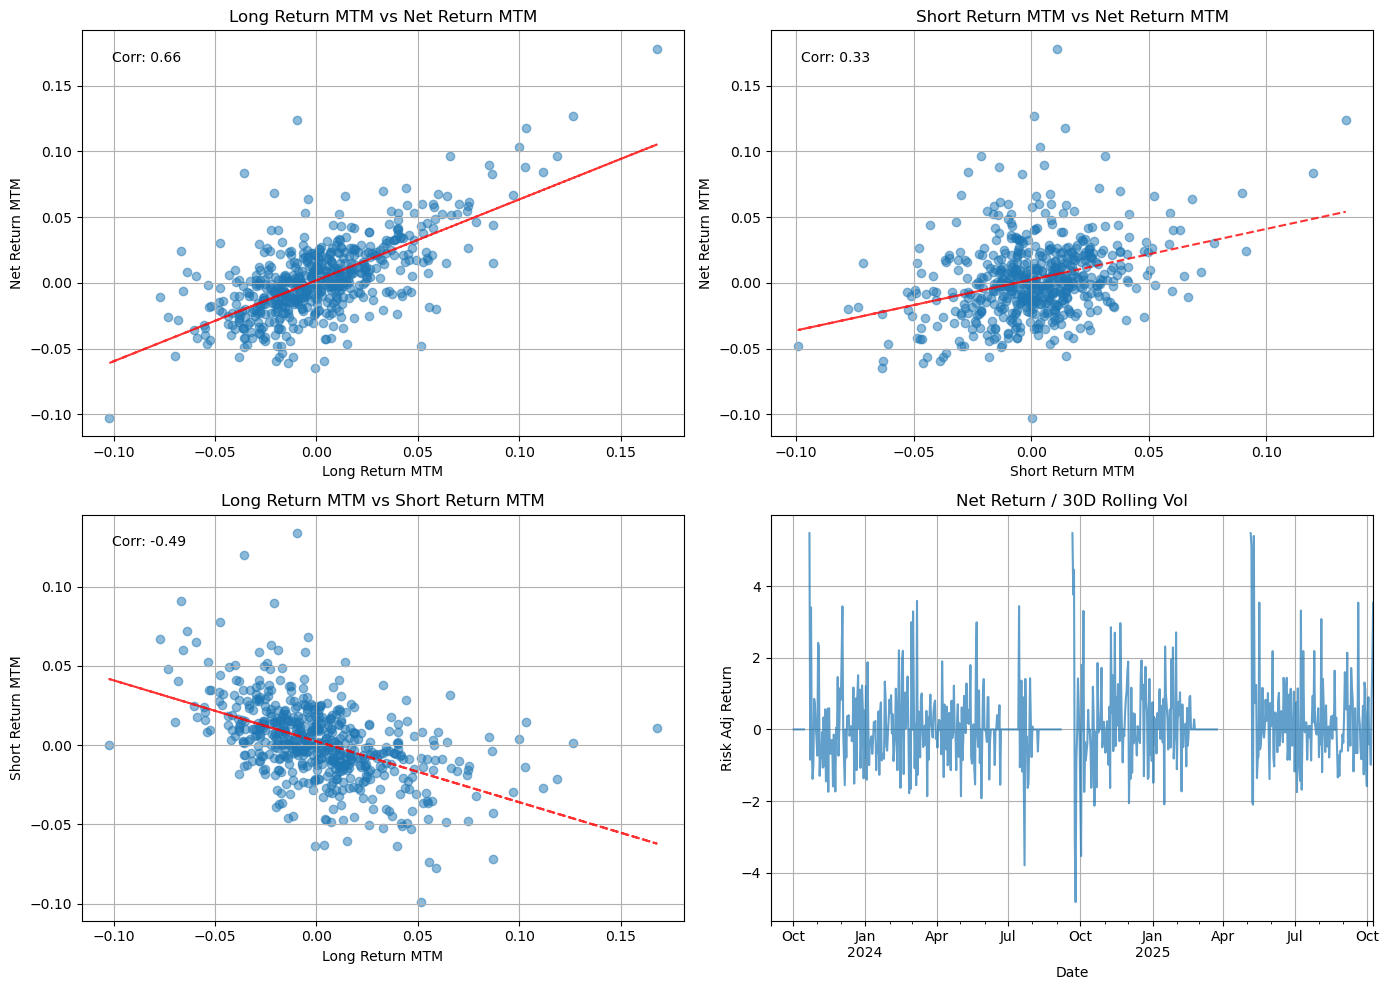

In [61]:
# Align data for scatter plots
ln_data = pd.merge(long_trading_day_ret, net_trading_day_ret, on='date')
sn_data = pd.merge(short_trading_day_ret, net_trading_day_ret, on='date')
ls_data = pd.merge(long_trading_day_ret, short_trading_day_ret, on='date')

plt.subplot(2,2,1)
x, y = ln_data['long_return_mtm'], ln_data['net_return_mtm']
plt.scatter(x, y, alpha=0.5)
if len(x) > 1:
    m, b = np.polyfit(x, y, 1)
    plt.plot(x, m*x + b, 'r--', alpha=0.8)
plt.text(0.05, 0.95, f"Corr: {x.corr(y):.2f}", transform=plt.gca().transAxes, va='top')
plt.title('Long Return MTM vs Net Return MTM')
plt.xlabel('Long Return MTM')
plt.ylabel('Net Return MTM')
plt.grid(True)

plt.subplot(2,2,2)
x, y = sn_data['short_return_mtm'], sn_data['net_return_mtm']
plt.scatter(x, y, alpha=0.5)
if len(x) > 1:
    m, b = np.polyfit(x, y, 1)
    plt.plot(x, m*x + b, 'r--', alpha=0.8)
plt.text(0.05, 0.95, f"Corr: {x.corr(y):.2f}", transform=plt.gca().transAxes, va='top')
plt.title('Short Return MTM vs Net Return MTM')
plt.xlabel('Short Return MTM')
plt.ylabel('Net Return MTM')
plt.grid(True)

plt.subplot(2,2,3)
x, y = ls_data['long_return_mtm'], ls_data['short_return_mtm']
plt.scatter(x, y, alpha=0.5)
if len(x) > 1:
    m, b = np.polyfit(x, y, 1)
    plt.plot(x, m*x + b, 'r--', alpha=0.8)
plt.text(0.05, 0.95, f"Corr: {x.corr(y):.2f}", transform=plt.gca().transAxes, va='top')
plt.title('Long Return MTM vs Short Return MTM')
plt.xlabel('Long Return MTM')
plt.ylabel('Short Return MTM')  
plt.grid(True)

plt.subplot(2,2,4)
# Calculate rolling vol (30 days)
rolling_vol = return_df.set_index('date')['net_return_mtm'].rolling(window=30).std()
# Alpha (Net Return) / Rolling Vol
risk_adj_ret = return_df.set_index('date')['net_return_mtm'] / rolling_vol
risk_adj_ret.plot(alpha=0.7)
plt.title('Net Return / 30D Rolling Vol')
plt.xlabel('Date')
plt.ylabel('Risk Adj Return')
plt.grid(True)

plt.tight_layout()

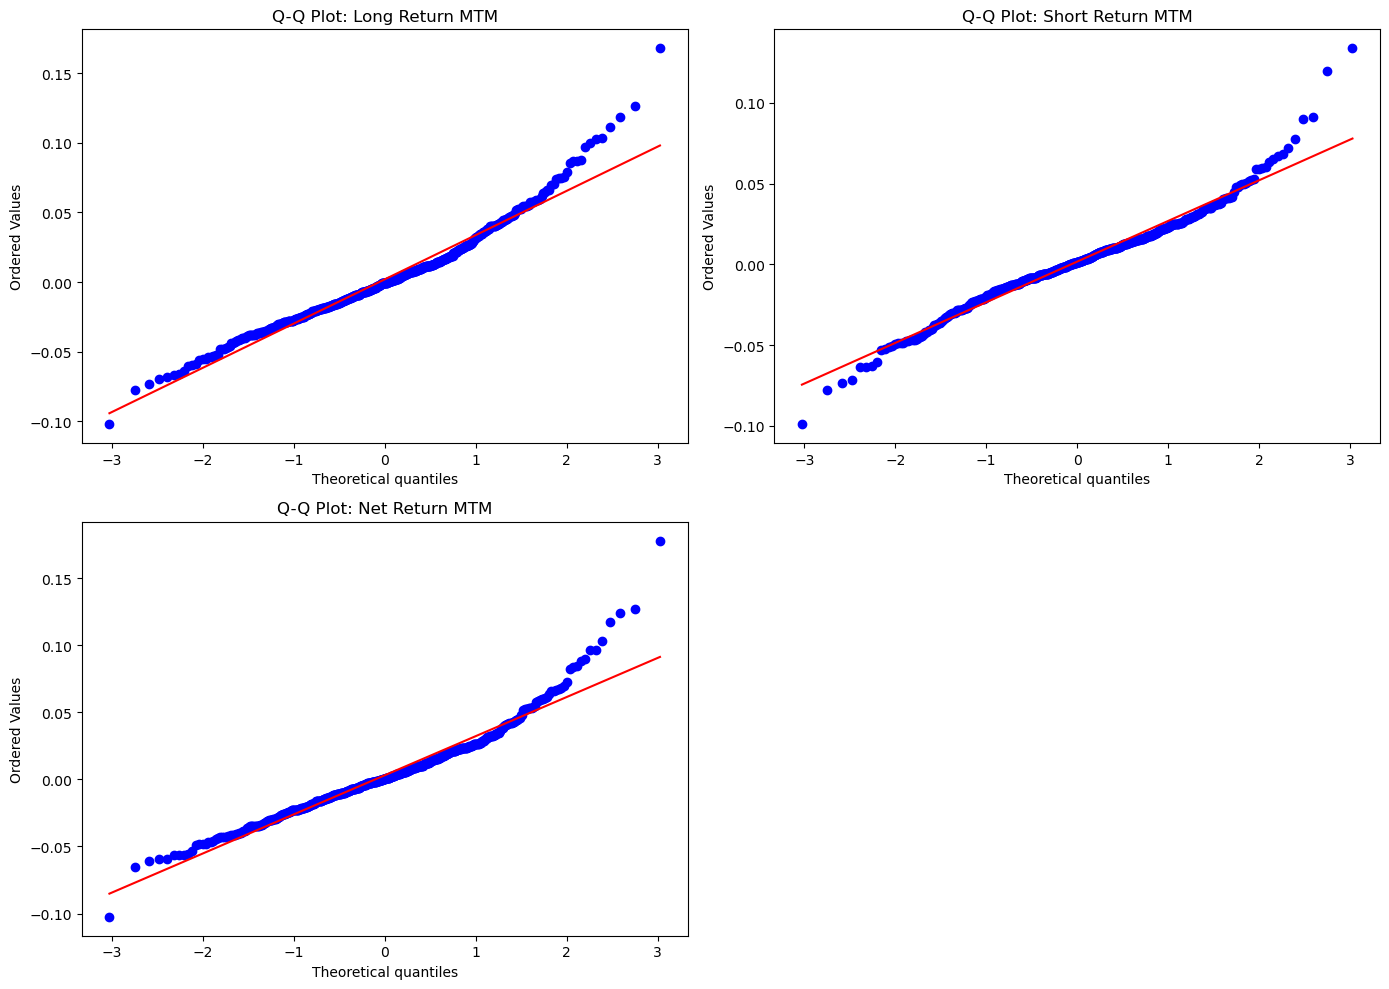

In [63]:
plt.subplot(2,2,1)
stats.probplot(ln_data['long_return_mtm'], dist="norm", plot=plt)
plt.title('Q-Q Plot: Long Return MTM')
plt.subplot(2,2,2)
stats.probplot(sn_data['short_return_mtm'], dist="norm", plot=plt)
plt.title('Q-Q Plot: Short Return MTM')
plt.subplot(2,2,3)
stats.probplot(ln_data['net_return_mtm'], dist="norm", plot=plt)
plt.title('Q-Q Plot: Net Return MTM')
plt.tight_layout()

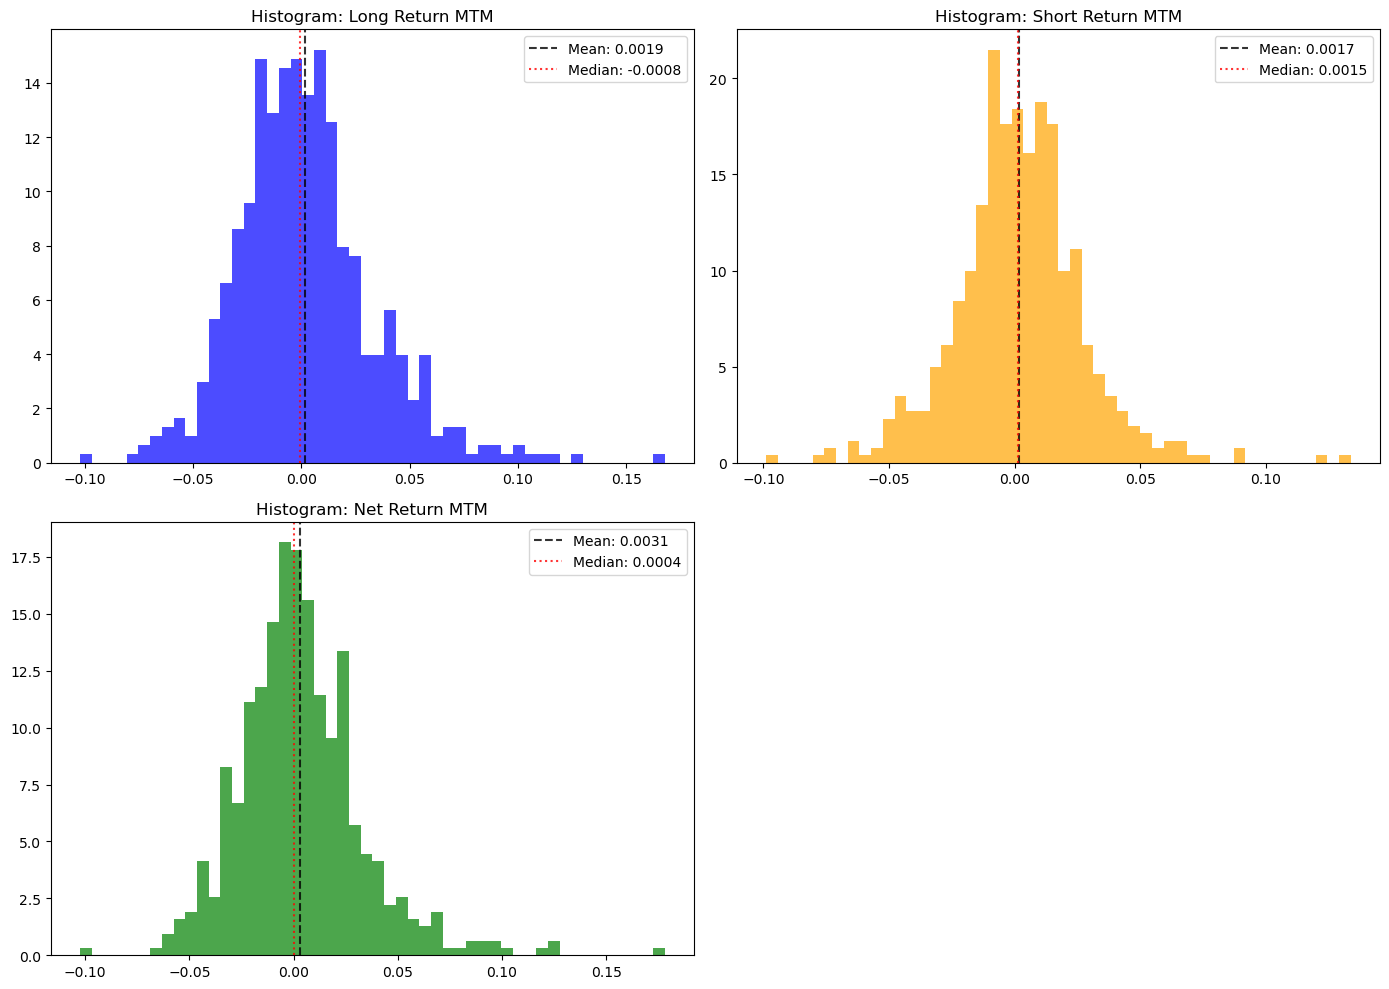

In [66]:
plt.subplot(2,2,1)
plt.hist(ln_data['long_return_mtm'], bins=50, alpha=0.7, color='blue', density=True)
plt.axvline(x=ln_data['long_return_mtm'].mean(), color='black', linestyle='--', alpha=0.8, label=f'Mean: {ln_data["long_return_mtm"].mean():.4f}')
plt.axvline(x=ln_data['long_return_mtm'].median(), color='red', linestyle=':', alpha=0.8, label=f'Median: {ln_data["long_return_mtm"].median():.4f}')
plt.title('Histogram: Long Return MTM')
plt.legend()

plt.subplot(2,2,2)
plt.hist(sn_data['short_return_mtm'], bins=50, alpha=0.7 , color='orange', density=True)
plt.axvline(x=sn_data['short_return_mtm'].mean(), color='black', linestyle='--', alpha=0.8, label=f'Mean: {sn_data["short_return_mtm"].mean():.4f}')
plt.axvline(x=sn_data['short_return_mtm'].median(), color='red', linestyle=':', alpha=0.8, label=f'Median: {sn_data["short_return_mtm"].median():.4f}')
plt.title('Histogram: Short Return MTM')
plt.legend()

plt.subplot(2,2,3)
plt.hist(ln_data['net_return_mtm'], bins=50, alpha=0.7 , color='green', density=True)
plt.axvline(x=ln_data['net_return_mtm'].mean(), color='black', linestyle='--', alpha=0.8, label=f'Mean: {ln_data["net_return_mtm"].mean():.4f}')
plt.axvline(x=ln_data['net_return_mtm'].median(), color='red', linestyle=':', alpha=0.8, label=f'Median: {ln_data["net_return_mtm"].median():.4f}')
plt.title('Histogram: Net Return MTM')
plt.legend()

plt.tight_layout()

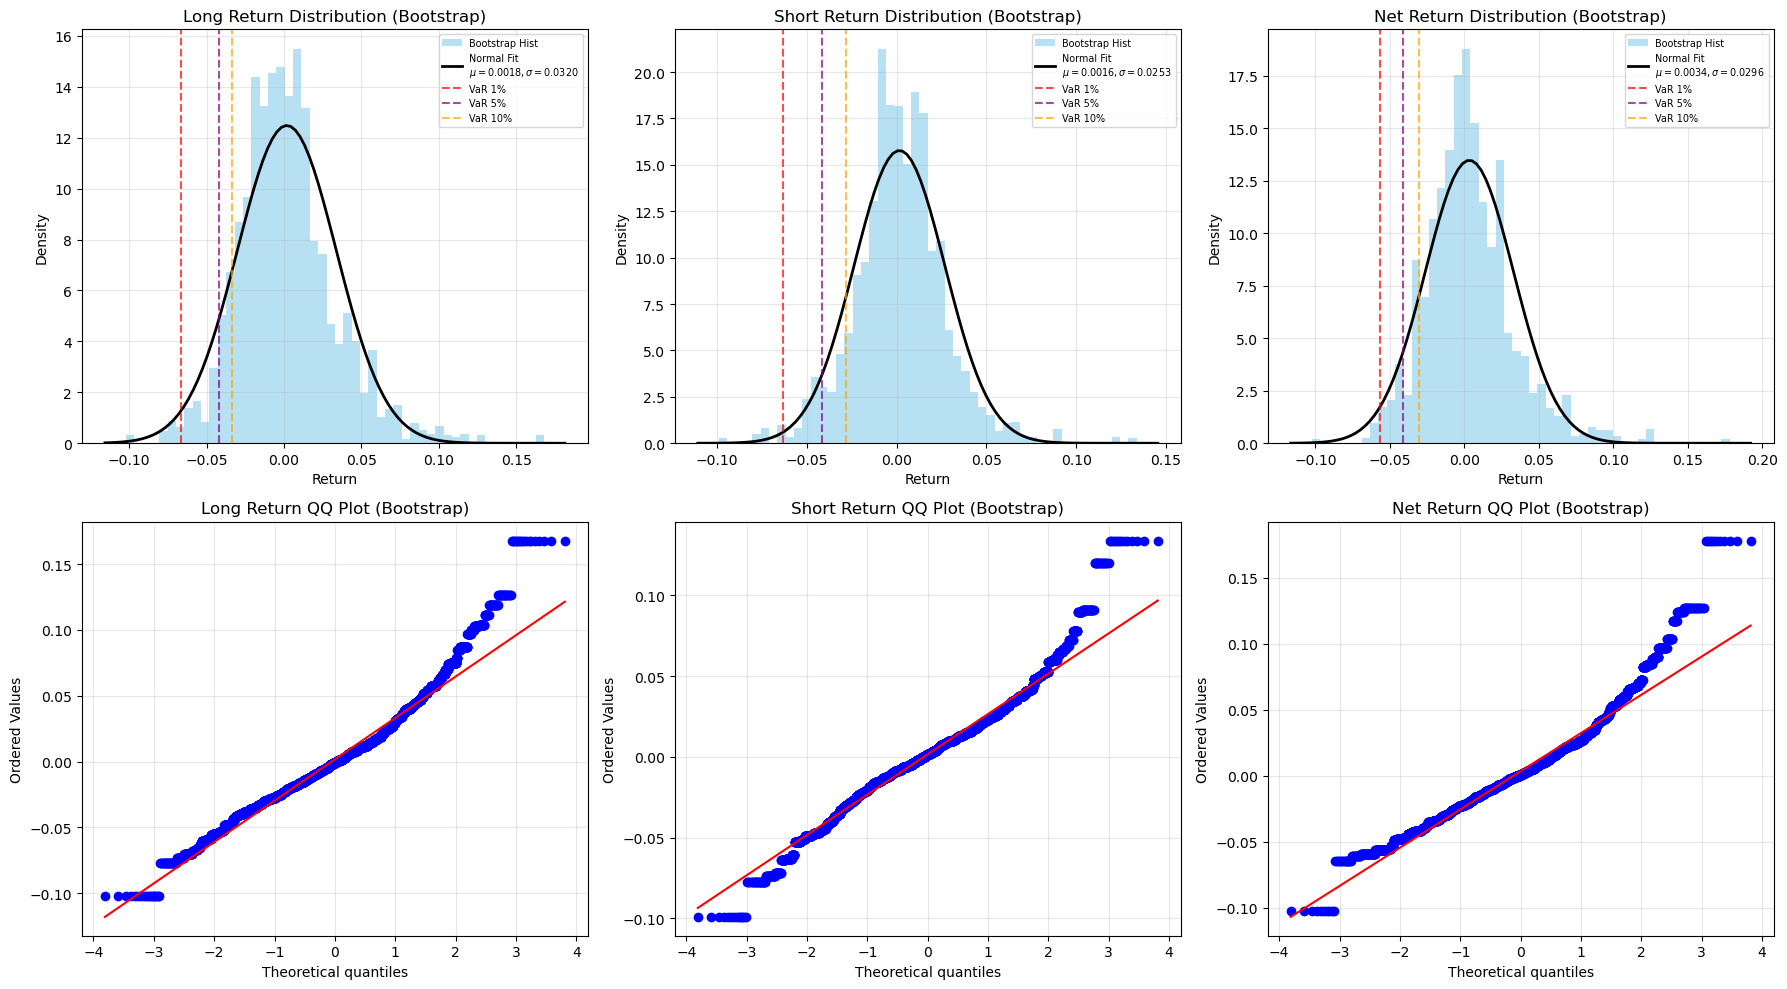

,Mean,Std,VaR 1%,CVaR 1%,VaR 5%,CVaR 5%,VaR 10%,CVaR 10%
Series,,,,,,,,
Long Return,0.001779,0.031970,-0.066793,-0.077980,-0.042110,-0.057469,-0.033574,-0.047676
Short Return,0.001600,0.025294,-0.063343,-0.074734,-0.041565,-0.053670,-0.028261,-0.043943
Net Return,0.003383,0.029593,-0.056470,-0.063967,-0.040852,-0.050046,-0.030265,-0.042299


In [68]:
# IID Bootstrap Analysis with Normal Fit, VaR, CVaR, and QQ Plots
n_bootstrap = 10000
confidence_levels = [0.01, 0.05, 0.10]  # 1%, 5%, 10%

datasets = {
    'Long Return': long_trading_day_ret['long_return_mtm'],
    'Short Return': short_trading_day_ret['short_return_mtm'],
    'Net Return': net_trading_day_ret['net_return_mtm']
}

plt.figure(figsize=(18, 10))  # Increased height for 2 rows of plots
results = []

for i, (label, data) in enumerate(datasets.items(), 1):
    # IID Bootstrap Resampling
    bootstrapped_data = np.random.choice(data, size=n_bootstrap, replace=True)
    
    # Calculate Metrics
    metrics = {
        'Series': label,
        'Mean': np.mean(bootstrapped_data),
        'Std': np.std(bootstrapped_data)
    }
    
    # Calculate VaR and CVaR for each confidence level
    for conf in confidence_levels:
        var_val = np.percentile(bootstrapped_data, conf * 100)
        cvar_val = bootstrapped_data[bootstrapped_data <= var_val].mean()
        metrics[f'VaR {conf*100:.0f}%'] = var_val
        metrics[f'CVaR {conf*100:.0f}%'] = cvar_val
    
    results.append(metrics)
    
    # --- Plot 1: Histogram with Normal Fit & Risk Lines ---
    plt.subplot(2, 3, i)
    plt.hist(bootstrapped_data, bins=50, density=True, alpha=0.6, color='skyblue', edgecolor='none', label='Bootstrap Hist')
    
    # Fit Normal Distribution
    mu, std = stats.norm.fit(bootstrapped_data)
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = stats.norm.pdf(x, mu, std)
    plt.plot(x, p, 'k', linewidth=2, label=f'Normal Fit\n$\mu={mu:.4f}, \sigma={std:.4f}$')
    
    # Plot lines for the middle confidence level (e.g., 5%) to avoid clutter, or all
    # Let's plot just 5% for clarity in the legend, or iterate
    colors = ['red', 'purple', 'orange']
    for idx, conf in enumerate(confidence_levels):
        var_val = metrics[f'VaR {conf*100:.0f}%']
        plt.axvline(var_val, color=colors[idx], linestyle='--', alpha=0.7, label=f'VaR {conf*100:.0f}%')
    
    plt.title(f'{label} Distribution (Bootstrap)')
    plt.xlabel('Return')
    plt.ylabel('Density')
    plt.legend(fontsize='x-small')
    plt.grid(True, alpha=0.3)

    # --- Plot 2: QQ Plot ---
    plt.subplot(2, 3, i + 3)
    stats.probplot(bootstrapped_data, dist="norm", plot=plt)
    plt.title(f'{label} QQ Plot (Bootstrap)')
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Display Metrics Table
metrics_df = pd.DataFrame(results).set_index('Series')
# Reorder columns to group VaR/CVaR
cols = ['Mean', 'Std'] + [c for c in metrics_df.columns if 'VaR' in c or 'CVaR' in c]
metrics_df = metrics_df[cols]
metrics_df